
# <p style="text-align: center;">EE 380L: Data Mining</p>
# <p style="text-align: center;">Assignment 3</p>
## <p style="text-align: center;">Total points: 80</p>
## <p style="text-align: center;">Due: Tuesday, March 20th, submitted via Canvas by 11:59 pm</p>

### <p style="text-align: center;">Group members: Chia-Ju Chen (EID: cc65542) Minke Cheng (EID: mc65568)</p>
Your homework should be written in a **Jupyter notebook**. You may work in groups of two if you wish. Only one student per team needs to submit the assignment on Canvas.  But be sure to include name and UTID for both students.  Homework groups will be created and managed through Canvas, so please do not arbitrarily change your homework group.  

Also, please make sure your code runs and the graphics (and anything else) are displayed in your notebook before submitting. (%matplotlib inline)

# Question 1 - Gradient Descent (5+12+3 = 20pts)

In this question you will implement vanilla SGD and 2 adaptive gradient update techniques called Adagrad and Adadelta. In addition, you will also implement ridge regularization. 

1. Using stochastic gradient descent, derive the coefficent updates for all 4 coefficients of the model: $$ y = w_0 + w_1*x_1 + w_2*x_1*x_1 + w_3*x_2*x_2 + w_4*x_2 $$ Hint: start from the cost function (Assume sum of squared error). If you write the math by hand, submit that as a separate file and make a reference to it in your notebook or include the image in your notebook.
2. Write Python code for an SGD solution to the non-linear model $$ y = w_0 + w_1*x_1 + w_2*x_1*x_1 + w_3*x_2*x_2 + w_4*x_2 $$ Try to format similarly to scikit-learn's models. Your Python class should take as input the learning_rate, regularization_constant and number of epochs. The fit method must take as input X,y and a choice of update_rule as 'SGD', 'adagrad' or 'adadelta' (Notes on implementation below). The _predict_ method takes an X value (optionally, an array of values). Use your new gradient descent regression to predict the data given in 'samples.csv', for 20 epochs (this may have to increase for adadelta), using learning rates: [.0001, .001, .01, 0.1, 1, 10, 100] and regularization constants in the range: [0,10,100] . Plot MSE and the $w$ parameters as a function of epoch count (20 epochs) for the best combination of learning_rate and regularization for both SGD, Adagrad and Adadelta. ie you should have a plot of MSE and parameter updates for SGD, adagrad and adadelta. Report the MSE at the end of 10 epochs for all 3.
3. Based on the experiments, answer the following:

1. Among SGD and Adagrad, which one allows for larger initial setting of the learning_rate? Why?
2. Mention one benefit and one drawback of Adadelta over Adagrad

## Answer:

### 1)  
The cost function can be written as below:  
$$J(w) = \frac{1}{m} \sum_{i = 1}^{m} (y - y_{target})^2 + \lambda ||w||^2$$
Where $ y = w_0 + w_1*x_1 + w_2*x_1*x_1 + w_3*x_2*x_2 + w_4*x_2 $, and $y_{target}$ is the target value given a set of $\textbf{x}$.  
So we have 
$$
\begin{align}
\frac{\partial}{\partial w_{j}} J(w) = &  \frac{\partial}{\partial w_{j}} \frac{1}{m} \sum_{i = 1}^{m} (y - y_{target})^2 + \lambda ||w||^2\\
= & 2 \cdot \frac{1}{m} \sum_{i = 1}^{m} (y - y_{target}) \cdot \frac{\partial}{\partial w_{i}} (y - y_{target}) + 2 \lambda w_{j}
\end{align}
$$
As for SGD, we only need to pick one piece of data to update the coefficient, so we let
$$ 
\frac{\partial}{\partial w_{j}} J(w) = 2 \cdot (y_i - y_{iTarget}) · \frac{\partial}{\partial w_{i}} (y_i - y_{iTarget}) + 2 \lambda w_{j}\\
\begin{align}
\Rightarrow \ & w_0^{\tau + 1} = w_0^{\tau} - \eta \frac{\partial}{\partial w_0} J(w) = w_0^{\tau} - 2 \eta (y_i - y_{iTarget}) - 2\eta \lambda w_0^{\tau}\\
& w_1^{\tau + 1} = w_1^{\tau} - \eta \frac{\partial}{\partial w_1} J(w) = w_1^{\tau} - 2 \eta (y_i - y_{iTarget}) x_{i1} - 2\eta \lambda w_1^{\tau} \\
& w_2^{\tau + 1} = w_2^{\tau} - \eta \frac{\partial}{\partial w_2} J(w) = w_2^{\tau} - 2 \eta (y_i - y_{iTarget}) x_{i1}^2 - 2\eta \lambda w_2^{\tau} \\
& w_3^{\tau + 1} = w_3^{\tau} - \eta \frac{\partial}{\partial w_3} J(w) = w_3^{\tau} - 2 \eta (y_i - y_{iTarget}) x_{i2}^2 - 2\eta \lambda w_3^{\tau}\\
& w_4^{\tau + 1} = w_4^{\tau} - \eta \frac{\partial}{\partial w_4} J(w) = w_4^{\tau} - 2 \eta (y_i - y_{iTarget}) x_{i2} - 2\eta \lambda w_4^{\tau}\\
\end{align}
$$
Where $\eta$ is the learning rate, $y_i$ is the predicted value of the model given a random piece of data $i$ in dataset with all coefficients of $\tau$, $y_{iTarget}$ is the target value of data $i$, $x_{i1}$ is $x_1$ in data i and $x_{i2}$ is $x_2$ in data $i$.

### 2)

In [258]:
import pandas as pd
from sklearn.linear_model import SGDRegressor
import numpy as np
import sys
import copy

class Regressor:
    def __init__(self, learning_rate, regularization_constant, epochs):
        self.learning_rate = learning_rate
        self.regularization_constant = regularization_constant
        self.epochs = epochs
        self.weights = [0, 0, 0, 0, 0]
        self.weights_record = []
        self.mse_record = []
        self.cache = [0, 0, 0, 0, 0]
        self.cache2 = [0, 0, 0, 0, 0]
        self.deltaomega = [0, 0, 0, 0, 0]

    def fit(self, X, y, update_rule):
        if(update_rule == 'SGD'):
            for i in range(self.epochs):
                for j in range(len(y)):
                    delta = np.dot(X.iloc[j], self.weights) - y[j]
                    self.weights[0] = self.weights[0] - 2 * self.learning_rate * delta \
                        - 2 * self.learning_rate * self.regularization_constant * self.weights[0]
                    self.weights[1] = self.weights[1] - 2 * self.learning_rate * delta * X.iloc[j,1] \
                        - 2 * self.learning_rate * self.regularization_constant * self.weights[1]
                    self.weights[2] = self.weights[2] - 2 * self.learning_rate * delta * X.iloc[j,2] \
                        - 2 * self.learning_rate * self.regularization_constant * self.weights[2]
                    self.weights[3] = self.weights[3] - 2 * self.learning_rate * delta * X.iloc[j,3] \
                        - 2 * self.learning_rate * self.regularization_constant * self.weights[3]
                    self.weights[4] = self.weights[4] - 2 * self.learning_rate * delta * X.iloc[j,4] \
                        - 2 * self.learning_rate * self.regularization_constant * self.weights[4]
                self.weights_record.append(copy.deepcopy(self.weights))
                self.mse_record.append(np.mean((np.dot(self.weights, np.transpose(X)) - y) ** 2))
        
        elif(update_rule == 'adagrad'):
            for i in range(self.epochs):
                for j in range(len(y)):
                    delta = np.dot(X.iloc[j], self.weights) - y[j]

                    gradients_0 = 2 * delta + 2 * self.regularization_constant * self.weights[0]
                    self.cache[0] = self.cache[0] + gradients_0 ** 2
                    self.weights[0] = self.weights[0] - self.learning_rate / np.sqrt(self.cache[0] + 10 ** (-6)) * gradients_0

                    gradients_1 = 2 * delta * X.iloc[j,1]+ 2 * self.regularization_constant * self.weights[1]
                    self.cache[1] = self.cache[1] + gradients_1 ** 2
                    self.weights[1] = self.weights[1] - self.learning_rate / np.sqrt(self.cache[1] + 10 ** (-6)) * gradients_1

                    gradients_2 = 2 * delta * X.iloc[j,2]+ 2 * self.regularization_constant * self.weights[2]
                    self.cache[2] = self.cache[2] + gradients_2 ** 2
                    self.weights[2] = self.weights[2] - self.learning_rate / np.sqrt(self.cache[2] + 10 ** (-6)) * gradients_2

                    gradients_3 = 2 * delta * X.iloc[j,3]+ 2 * self.regularization_constant * self.weights[3]
                    self.cache[3] = self.cache[3] + gradients_3 ** 2
                    self.weights[3] = self.weights[3] - self.learning_rate / np.sqrt(self.cache[3] + 10 ** (-6)) * gradients_3

                    gradients_4 = 2 * delta * X.iloc[j,4]+ 2 * self.regularization_constant * self.weights[4]
                    self.cache[4] = self.cache[4] + gradients_4 ** 2
                    self.weights[4] = self.weights[4] - self.learning_rate / np.sqrt(self.cache[4] + 10 ** (-6)) * gradients_4

                self.weights_record.append(copy.deepcopy(self.weights))
                self.mse_record.append(np.mean((np.dot(self.weights, np.transpose(X)) - y) ** 2))

        elif(update_rule == 'adadelta'):
            gamma = 0.9
            for i in range(self.epochs):
                for j in range(len(y)):
                    delta = np.dot(X.iloc[j], self.weights) - y[j]

                    gradients_0 = 2 * delta + 2 * self.regularization_constant * self.weights[0]
                    self.cache[0] = gamma * self.cache[0] + (1 - gamma) * gradients_0 ** 2
                    self.cache2[0] = gamma * self.cache2[0] + (1 - gamma) * self.deltaomega[0] ** 2
                    temp = self.weights[0]
                    self.weights[0] = self.weights[0] - np.sqrt(self.cache2[0] + 10 ** (-6)) / np.sqrt(self.cache[0] + 10 ** (-6)) * gradients_0
                    self.deltaomega[0] = self.weights[0] - temp

                    gradients_1 = 2 * delta * X.iloc[j,1]+ 2 * self.regularization_constant * self.weights[1]
                    self.cache[1] = gamma * self.cache[1] + (1 - gamma) * gradients_1 ** 2
                    self.cache2[1] = gamma * self.cache2[1] + (1 - gamma) * self.deltaomega[1] ** 2
                    temp = self.weights[1]
                    self.weights[1] = self.weights[1] - np.sqrt(self.cache2[1] + 10 ** (-6)) / np.sqrt(self.cache[1] + 10 ** (-6)) * gradients_1
                    self.deltaomega[1] = self.weights[1] - temp

                    gradients_2 = 2 * delta * X.iloc[j,2]+ 2 * self.regularization_constant * self.weights[2]
                    self.cache[2] = gamma * self.cache[2] + (1 - gamma) * gradients_2 ** 2
                    self.cache2[2] = gamma * self.cache2[2] + (1 - gamma) * self.deltaomega[2] ** 2
                    temp = self.weights[2]
                    self.weights[2] = self.weights[2] - np.sqrt(self.cache2[2] + 10 ** (-6)) / np.sqrt(self.cache[2] + 10 ** (-6)) * gradients_2
                    self.deltaomega[2] = self.weights[2] - temp

                    gradients_3 = 2 * delta * X.iloc[j,3]+ 2 * self.regularization_constant * self.weights[3]
                    self.cache[3] = gamma * self.cache[3] + (1 - gamma) * gradients_3 ** 2
                    self.cache2[3] = gamma * self.cache2[3] + (1 - gamma) * self.deltaomega[3] ** 2
                    temp = self.weights[3]
                    self.weights[3] = self.weights[3] - np.sqrt(self.cache2[3] + 10 ** (-6)) / np.sqrt(self.cache[3] + 10 ** (-6)) * gradients_3
                    self.deltaomega[3] = self.weights[3] - temp

                    gradients_4 = 2 * delta * X.iloc[j,4]+ 2 * self.regularization_constant * self.weights[4]
                    self.cache[4] = gamma * self.cache[4] + (1 - gamma) * gradients_4 ** 2
                    self.cache2[4] = gamma * self.cache2[4] + (1 - gamma) * self.deltaomega[4] ** 2
                    temp = self.weights[4]
                    self.weights[4] = self.weights[4] - np.sqrt(self.cache2[4] + 10 ** (-6)) / np.sqrt(self.cache[4] + 10 ** (-6)) * gradients_4
                    self.deltaomega[4] = self.weights[4] - temp

                self.weights_record.append(copy.deepcopy(self.weights))
                self.mse_record.append(np.mean((np.dot(self.weights, np.transpose(X)) - y) ** 2))

    def predict(self, X):
        output = []
        for i in range(X.shape[0]):
            output.append(np.dot(X.iloc[i], self.weights))
        return output

In [267]:
if __name__ == "__main__":

    data = pd.read_csv('samples.csv')

    x1 = data['x_1']
    x2 = data['x_2']
    x1_square = x1 ** 2
    x2_square = x2 ** 2
    ones = [1 for i in range(len(x1))]
    X = pd.concat([x1, x1_square, x2_square, x2], axis = 1)
    X.columns = ['x_1', 'x_1_square', 'x_2_square', 'x_2']
    X.insert(0, 'bias', ones)

    y = data['y']
    
    learning_rate = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100] 
    regularization_constant = [0, 10, 100]
    epochs = 20
    bestSGDindex = [0, 0]
    min_mse = sys.maxsize
    
    for i in range(len(learning_rate)):
        for j in range(len(regularization_constant)):
            model = Regressor(learning_rate[i], regularization_constant[j], epochs)
            model.fit(X, y, 'SGD')
            if not np.isnan(model.mse_record[-1]):
                if model.mse_record[-1] < min_mse:
                    bestSGDindex[0] = i
                    bestSGDindex[1] = j
                    min_mse = model.mse_record[-1]
    
    print("Best combination of learning rate and regularization for SGD can be: ")
    print("learning rate: "+ str(learning_rate[bestSGDindex[0]]))
    print("regularization constant: "+ str(regularization_constant[bestSGDindex[1]]))

Best combination of learning rate and regularization for SGD can be: 
learning rate: 0.1
regularization constant: 0


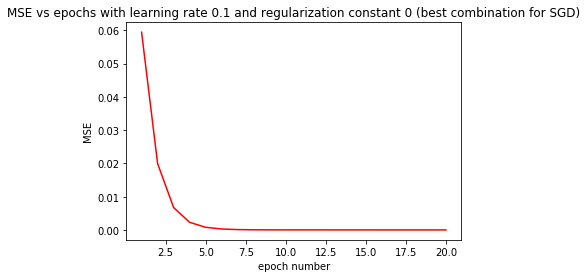

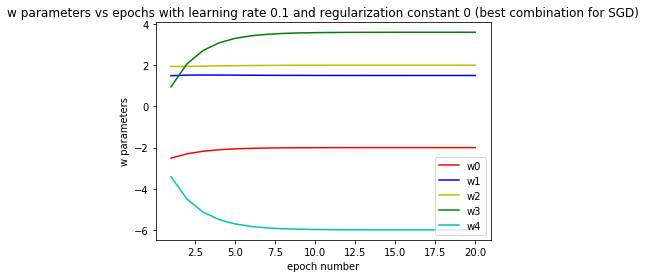

MSE at the end of 10 epochs:
1.0485119065865068e-05


In [268]:
import matplotlib.pyplot as plt
if __name__ == "__main__":
    learning_rate = 0.1
    regularization_constant = 0
    epochs = 20
    model = Regressor(learning_rate, regularization_constant, epochs)
    model.fit(X, y, 'SGD')
    mse_plot, = plt.plot([i+1 for i in range(20)], model.mse_record, 'r')
    plt.xlabel('epoch number')
    plt.ylabel('MSE')
    plt.title('MSE vs epochs with learning rate 0.1 and regularization constant 0 (best combination for SGD)')
    plt.show()
    
    w0_plot, = plt.plot([i+1 for i in range(20)], [e[0] for e in model.weights_record], 'r', label='w0')
    w1_plot, = plt.plot([i+1 for i in range(20)], [e[1] for e in model.weights_record], 'b', label='w1')
    w2_plot, = plt.plot([i+1 for i in range(20)], [e[2] for e in model.weights_record], 'y', label='w2')
    w3_plot, = plt.plot([i+1 for i in range(20)], [e[3] for e in model.weights_record], 'g', label='w3')
    w4_plot, = plt.plot([i+1 for i in range(20)], [e[4] for e in model.weights_record], 'c', label='w4')
    plt.legend(handles=[w0_plot, w1_plot, w2_plot, w3_plot, w4_plot])
    plt.xlabel('epoch number')
    plt.ylabel('w parameters')
    plt.title('w parameters vs epochs with learning rate 0.1 and regularization constant 0 (best combination for SGD)')
    plt.show()
    print("MSE at the end of 10 epochs:")
    print(model.mse_record[9])

In [269]:
if __name__ == "__main__":

    data = pd.read_csv('samples.csv')

    x1 = data['x_1']
    x2 = data['x_2']
    x1_square = x1 ** 2
    x2_square = x2 ** 2
    ones = [1 for i in range(len(x1))]
    X = pd.concat([x1, x1_square, x2_square, x2], axis = 1)
    X.columns = ['x_1', 'x_1_square', 'x_2_square', 'x_2']
    X.insert(0, 'bias', ones)

    y = data['y']
    
    learning_rate = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100] 
    regularization_constant = [0, 10, 100]
    epochs = 20
    bestAdagradindex = [0, 0]
    min_mse = sys.maxsize
    
    for i in range(len(learning_rate)):
        for j in range(len(regularization_constant)):
            model = Regressor(learning_rate[i], regularization_constant[j], epochs)
            model.fit(X, y, 'adagrad')
            if not np.isnan(model.mse_record[-1]):
                if model.mse_record[-1] < min_mse:
#                     print(str(i) + " " + str(j) + " " + str(model.mse_record[-1]))
                    bestAdagradindex[0] = i
                    bestAdagradindex[1] = j
                    min_mse = model.mse_record[-1]
    
    print("Best combination of learning rate and regularization for Adagrad can be: ")
    print("learning rate: "+ str(learning_rate[bestAdagradindex[0]]))
    print("regularization constant: "+ str(regularization_constant[bestAdagradindex[1]]))

Best combination of learning rate and regularization for Adagrad can be: 
learning rate: 1
regularization constant: 0


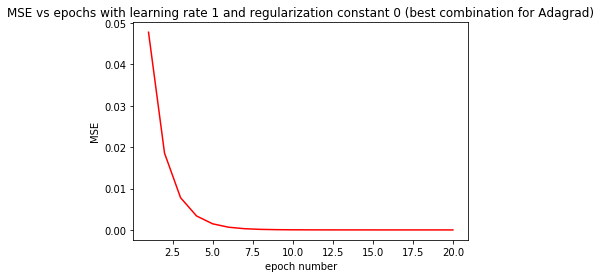

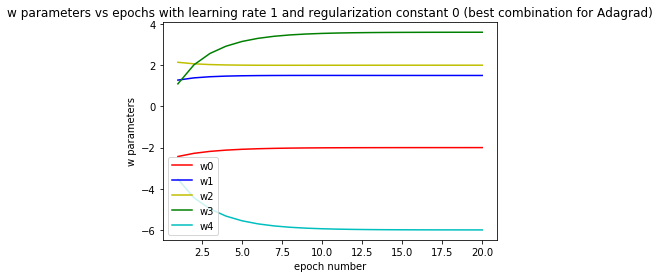

MSE at the end of 10 epochs:
3.022435340563938e-05


In [273]:
if __name__ == "__main__":
    learning_rate = 1
    regularization_constant = 0
    epochs = 20
    model = Regressor(learning_rate, regularization_constant, epochs)
    model.fit(X, y, 'adagrad')
    mse_plot, = plt.plot([i+1 for i in range(20)], model.mse_record, 'r')
    plt.xlabel('epoch number')
    plt.ylabel('MSE')
    plt.title('MSE vs epochs with learning rate 1 and regularization constant 0 (best combination for Adagrad)')
    plt.show()
    
    w0_plot, = plt.plot([i+1 for i in range(20)], [e[0] for e in model.weights_record], 'r', label='w0')
    w1_plot, = plt.plot([i+1 for i in range(20)], [e[1] for e in model.weights_record], 'b', label='w1')
    w2_plot, = plt.plot([i+1 for i in range(20)], [e[2] for e in model.weights_record], 'y', label='w2')
    w3_plot, = plt.plot([i+1 for i in range(20)], [e[3] for e in model.weights_record], 'g', label='w3')
    w4_plot, = plt.plot([i+1 for i in range(20)], [e[4] for e in model.weights_record], 'c', label='w4')
    plt.legend(handles=[w0_plot, w1_plot, w2_plot, w3_plot, w4_plot])
    plt.xlabel('epoch number')
    plt.ylabel('w parameters')
    plt.title('w parameters vs epochs with learning rate 1 and regularization constant 0 (best combination for Adagrad)')
    plt.show()
    print("MSE at the end of 10 epochs:")
    print(model.mse_record[9])

In [271]:
if __name__ == "__main__":

    data = pd.read_csv('samples.csv')

    x1 = data['x_1']
    x2 = data['x_2']
    x1_square = x1 ** 2
    x2_square = x2 ** 2
    ones = [1 for i in range(len(x1))]
    X = pd.concat([x1, x1_square, x2_square, x2], axis = 1)
    X.columns = ['x_1', 'x_1_square', 'x_2_square', 'x_2']
    X.insert(0, 'bias', ones)

    y = data['y']
    
    regularization_constant = [0, 10, 100]
    epochs = 100
    bestAdadeltaindex = 0
    min_mse = sys.maxsize
    
    for j in range(len(regularization_constant)):
        model = Regressor(0.1, regularization_constant[j], epochs)
        model.fit(X, y, 'adadelta')
        if not np.isnan(model.mse_record[-1]):
            if model.mse_record[-1] < min_mse:
                bestAdadeltaindex = j
                min_mse = model.mse_record[-1]
#             print(str(j) + " " + str(model.mse_record[-1]))
    
    print("Best combination of learning rate and regularization for Adadelta can be: ")
    print("regularization constant: "+ str(regularization_constant[bestAdadeltaindex]))

Best combination of learning rate and regularization for Adadelta can be: 
regularization constant: 0


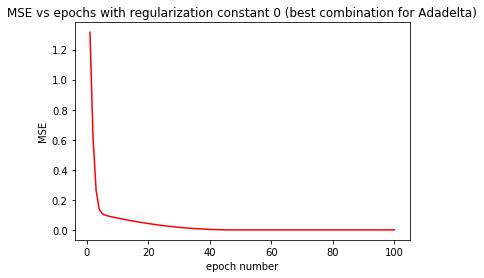

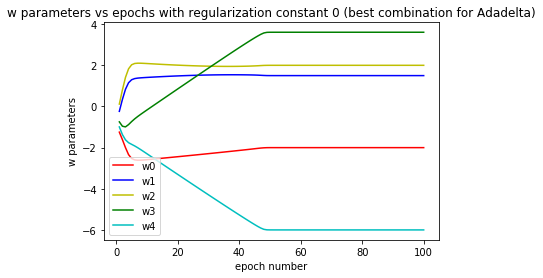

MSE at the end of 10 epochs:
0.07882334790751941


In [272]:
if __name__ == "__main__":
    regularization_constant = 0
    epochs = 100
    x_array = [i+1 for i in range(epochs)]
    model = Regressor(learning_rate, regularization_constant, epochs)
    model.fit(X, y, 'adadelta')
    mse_plot, = plt.plot(x_array, model.mse_record, 'r')
    plt.xlabel('epoch number')
    plt.ylabel('MSE')
    plt.title('MSE vs epochs with regularization constant 0 (best combination for Adadelta)')
    plt.show()
    
    w0_plot, = plt.plot(x_array, [e[0] for e in model.weights_record], 'r', label='w0')
    w1_plot, = plt.plot(x_array, [e[1] for e in model.weights_record], 'b', label='w1')
    w2_plot, = plt.plot(x_array, [e[2] for e in model.weights_record], 'y', label='w2')
    w3_plot, = plt.plot(x_array, [e[3] for e in model.weights_record], 'g', label='w3')
    w4_plot, = plt.plot(x_array, [e[4] for e in model.weights_record], 'c', label='w4')
    plt.legend(handles=[w0_plot, w1_plot, w2_plot, w3_plot, w4_plot])
    plt.xlabel('epoch number')
    plt.ylabel('w parameters')
    plt.title('w parameters vs epochs with regularization constant 0 (best combination for Adadelta)')
    plt.show()
    print("MSE at the end of 10 epochs:")
    print(model.mse_record[9])

### 3）
1.Among SGD and Adagrad, which one allows for larger initial setting of the learning_rate? Why?  
$\textbf{Answer:}$ Adagrad allows for larger initial setting of learning_rate. Because it can adapt the learning rate to the parameters. It helps perform smaller updates for frequent parameters and larger updates for infrequent parameters. Since Adagrad can adjust the actual learning rate adaptively, it is more tolerant of initial learning rate.  
  
2.Mention one benefit and one drawback of Adadelta over Adagrad?  
$\textbf{Answer:}$  
$\textbf{Benefit:}$ For Adadelta, instead of inefficiently storing w previous squared gradients, the sum of gradients is recursively defined as a decaying average of all past squared gradients. In this way, it can always reach better local minima. Also, it doesn't need to be set an initial learning rate.  
$\textbf{Drawback:}$ For Adadelta, it has slower convergence speed.

# Notes on Adagrad/Adadelta
Adagrad (http://ruder.io/optimizing-gradient-descent/) differs from vanilla SGD in that the learning rate of each weight changes over updates. A cache is maintained that holds the sum of squares of all gradients upto the current update. The learning_rate is divided by the cache, resulting in a different learning rate for each weight. A consequence of this update rule is that weights that have already seen large gradients (made large jumps) make smaller updates in subsequent iterations.
Specifically, the steps can be listed as below:
1. cache = cache + (gradients^2)
2. weights = weights + ((learning_rate)/sqrt(cache+1e-6))*gradients

The key difference between Adadelta and Adagrad is that the former uses a weighted sum for each update of the cache. Also, you will not need to use a learning rate to make Adadelta work. In addition to the link above, the paper on Adadelta is a great resource to implement it correctly (https://arxiv.org/pdf/1212.5701.pdf)

# (Optional) Notes on Training with Gradient Descent
1. Compute error: This consists of a prediction error and a regularization term. From an implementation perspective, this is a function that takes as input the truth, prediction and regularization hyperparameter and returns an error
2. Compute gradients: Take a derivative of the error in terms of the weights. This can be modelled as a function that takes as input the error and features and returns the gradients for each weight
3. Update weights: Weight updates can be done using vanilla SGD or adaptive techniques. The update function takes as inputs the gradient and hyperparameters and returns the new weights.

# Question 2. (6+4=10 pts) Tensor Playground
Visit http://playground.tensorflow.org for this problem

A. From the far right, select "Regression" as the problem type, and select the 2nd of the two data sets ( the right one ).  

   i) What sort of test / training loss do you get if you run it for 200 epochs with the following learning rates: .3, .01 and .003 ?  What if you run it for 1000 epochs with these learning rates?  Leave all other values at their defaults ( test/training ratio 50%, Noise 0, Batch Size 10, using Tanh activation function, and No Regularization )
   
   ii) Keeping learning rate at .3, Activation at Tanh, with all others at their defaults, and running for 200 epochs.  
     What sort of test/train loss can you achieve using only 1 neuron in the first hidden layer.  What about for 2,3 or 8 neurons?  Provide screen shots of output layer and comment on how the different output fits look and compare with one another.

   iii)Now keeping learning rate at .03 with all others at their defaults, and running for 200 epochs.  
       Compare how the activation functions affect the ouput ( ReLU, Sigmoid, Tanh, Linear ). Provide screen shots of output results and comment.


B. Neural Nets can fit anything.  Now reset to the initial defaults, and select "Classification" as the problem type, and from the Data section, select the bottom right "Spriral" data set.  With the idea of trying to minimize training/testing error, provide solutions to the problem for the following 2 scenarios.  i) Using just the first 2 inputs ( as per default ) and ii) Using all 7 of the inputs.  You may use as many layers as you want, whatever activation, however man neurons.  Provide screen shots which show your full network, output and parameters. Briefly justify your decisions, and comment on difficulties/tradeoffs, what helps/what doesn't,etc. 

## ANSWER

A.  
i)  
200 epochs with learning rate 0.3: Test loss: 0.021; Training loss: 0.017  
200 epochs with learning rate 0.01: Test loss: 0.024; Training loss: 0.020  
200 epochs with learning rate 0.003: Test loss: 0.048; Training loss: 0.039  
  
1000 epochs with learning rate 0.3: Test loss: 0.012; Training loss: 0.010  
1000 epochs with learning rate 0.01: Test loss: 0.018; Training loss: 0.015  
1000 epochs with learning rate 0.003: Test loss: 0.020; Training loss: 0.017  
  
ii)  
1 neuron: 
<img src="1neuron.png" class="gallery" alt="Drawing" style="width:500px;"/>

2 neuron:  
<img src="2neurons.png" class="gallery" alt="Drawing" style="width:500px;"/>  
  
3 neuron:  
<img src="3neurons.png" class="gallery" alt="Drawing" style="width:500px;"/>  
  
8 neuron:  
<img src="8neurons.png" class="gallery" alt="Drawing" style="width:500px;"/>  
We can find that with more hidden neurons, the loss will decrease, and the model can be non-linear so that it can perform better on regression.  
  
iii) 
ReLU: 
<img src="ReLU.png" class="gallery" alt="Drawing" style="width:500px;"/>

Sigmoid:  
<img src="Sigmoid.png" class="gallery" alt="Drawing" style="width:500px;"/>  
  
Tanh:  
<img src="Tanh.png" class="gallery" alt="Drawing" style="width:500px;"/>  
  
Linear:  
<img src="Linear.png" class="gallery" alt="Drawing" style="width:500px;"/>  
Here the Tanh activation function works the best, while Sigmoid and Linear don't perform so well. ReLU perform little worse than Tanh.  
  
B.  
Using first 2 inputs: 
<img src="2inputs.png" class="gallery" alt="Drawing" style="width:800px;"/>  
  
Using all 7 inputs: 
<img src="7inputs.png" class="gallery" alt="Drawing" style="width:800px;"/>  
Here for the both cases, I chose 5 hidden layers, 0.03 as the learning rate and tanh as the activation function. The difference between these two models are the number of hidden units. For the second case (7 inputs), I chose more hidden units because when the dimension of input data increases, there may be more potential features to be extracted, and thus the model should be more complicated. I chose 0.03 for the learning rate since the parameters fluctuate frequently with higher learning rate while the convergence speed keeps slow with lower learning rate. I chose tanh as the activation function because it always works better than sigmoid since its mean is 0. I didn't choose relu because it is not robust and units can easily become dead. One difficulty is SGD does not keeps the same during different try, so while I get a perfect model after one try, I might get a bad one after a new try with all parameters keeping the same.

# Question 3: Multi-layer Perceptron Regressor (15 points)

In this question, you will explore the application of Multi-layer Perceptron (MLP) regression using sklearn package in Python. We will use the OpenCL gemm kernel performance prediction dataset for this problem https://archive.ics.uci.edu/ml/datasets/SGEMM+GPU+kernel+performance.

Following code will pre-process the data and split the data into training and test set using [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with **random state 42** and **test_size = 0.33**.

In [284]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split,KFold)
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import glob
%matplotlib inline

data = pd.read_csv('sgemm_product.csv') 
data['target'] = 0.25*(data['Run1 (ms)'] + data['Run2 (ms)']+ data['Run3 (ms)'] + data['Run4 (ms)'])
y = data['target']
X = data.drop(['target','Run1 (ms)', 'Run2 (ms)', 'Run3 (ms)', 'Run4 (ms)'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(161872, 14) (161872,) (79728, 14) (79728,)


One more thing to use in this problem is [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Instead of fitting a model on original data, use StandardScaler to make each feature centered ([Example](http://scikit-learn.org/stable/auto_examples/applications/plot_prediction_latency.html#sphx-glr-auto-examples-applications-plot-prediction-latency-py)). Whenever you have training and test data, fit a scaler on training data and use this scaler on test data. Here, scale only features (independent variables), not target variable y.

Use [sklearn.neural_nework.MLPRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor) to do a 5-fold cross validation using sklearn's [KFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold). The cross validation must be performed on the **training data**. 

1) Use following parameter settings for MLPRegressor:

    activation = 'tanh', solver = 'sgd', learning_rate='constant', random_state=42,
    batch_size=5000, learning_rate_init = 0.005
    
Now, consider the following settings for the number of hidden units:
    
        (2,), (10,), (20,), (30,), (40,)
    
   Report the average Root Mean Squared Error (RMSE) value based on your 5-fold cross validation for each model (5pts)
      
2) Now, using the same number of hidden units used in part 1), train MLPRegressor models on whole training data and report RMSE score for both Train and Test set (Again, use StandardScaler). Which model works the best? Briefly analyze the result in terms of the number of hidden units. (3pts)

3) MLPRegressor has a built-in attribute *loss\_curve\_* which returns the loss at each epoch (misleadingly referred to as "iteration" in scikit documentation, though they use epoch in the actual code!). For example, if your model is named as *my_model* you can call it as *my\_model.loss\_curve\_* ([example](http://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html#sphx-glr-auto-examples-neural-networks-plot-mlp-training-curves-py)). Plot three curves for model (a), (b), and (c) in one figure, where *X-axis* is epoch  number and *Y-axis* is squared root of *loss\_curve\_* value. (2pts)

4) Activation Layer: Use the tanh and relu activations for the following fixed parameters to train your model:
    
    solver = 'sgd', random_state=42,
    batch_size=5000, hidden_layer_sizes = (2,)

   Report the average Root Mean Squared Error (RMSE) value based on your 5-fold cross validation for each model. (2pts)
   
5) Optimization technique: The sklearn API performs a momentum update when using SGD. To understand the difference in performance of vanilla SGD and SGD with momentum, set momentum to 0 with SGD. Here, we compare the performance of vanilla sgd against adam solvers. Since both of these use different optimization subroutines, the learning rate must also be varied. In this question, vary the learning rate through these values [1, 0.1, 0.01, 0.001]. Keep the following fixed parameters to train your model:

    activation = 'tanh', random_state=42,
    batch_size=5000, hidden_layer_sizes = (2,), momentum = 0
    
   Report the average Root Mean Squared Error (RMSE) value based on your 5-fold cross validation for the best learning rate for each model. (3pts)

## Solution

### 1)

In [285]:
kf = KFold(n_splits=5)

y_train = y_train.reset_index(drop='true')
y_test = y_test.reset_index(drop='true')

layer_setting = [(2,), (10,), (20,), (30,), (40,)]

for i in range(5):
    MLP1 = MLPRegressor(activation='tanh', hidden_layer_sizes=layer_setting[i], solver = 'sgd', learning_rate='constant', random_state=42, learning_rate_init = 0.005, batch_size=5000)
    MSE = 0
    for train_index, test_index in kf.split(X_train, y_train):

        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train_0 = X_train.iloc[train_index]
        X_test_0 = X_train.iloc[test_index]
        y_train_0 = y_train[train_index]
        y_test_0 = y_train[test_index]

        scaler = StandardScaler()
        scaler.fit(X_train_0)
        X_train_0 = scaler.transform(X_train_0)
        X_test_0 = scaler.transform(X_test_0)

        meanval = np.mean([item for item in y_train_0 if not np.isnan(item)])
        index = np.isnan(y_train_0)
        y_train_0[index] = meanval

        MLP1.fit(X_train_0, y_train_0)
        y_predict = MLP1.predict(X_test_0)

        meanval = np.mean([item for item in y_test_0 if not np.isnan(item)])
        index = np.isnan(y_test_0)
        y_test_0[index] = meanval
        
        MSE = MSE + np.sqrt(np.mean((y_test_0 - y_predict) ** 2))
    print("Average RMSE for " + str(layer_setting[i]) +  " hidden units is: ", MSE / 5)

Average RMSE for (2,) hidden units is:  231.045038856
Average RMSE for (10,) hidden units is:  90.0642472489
Average RMSE for (20,) hidden units is:  67.7476176755
Average RMSE for (30,) hidden units is:  56.2584744546
Average RMSE for (40,) hidden units is:  45.2544359237


### 2)

In [286]:
scaler = StandardScaler()
scaler0 = scaler.fit(X_train)
X_train_0 = scaler0.transform(X_train)
X_test_0 = scaler0.transform(X_test)
    
kf = KFold(n_splits=5)

layer_setting = [(2,), (10,), (20,), (30,), (40,)]

for i in range(5):
    MLP1 = MLPRegressor(activation='tanh', hidden_layer_sizes=layer_setting[i], solver = 'sgd', learning_rate='constant', random_state=42, learning_rate_init = 0.005, batch_size=5000)

    MLP1.fit(X_train_0, y_train)
    y_predict0 = MLP1.predict(X_train_0)
    y_predict = MLP1.predict(X_test_0)

    MSE_train = np.sqrt(np.mean((y_train - y_predict0) ** 2))
    MSE_test = np.sqrt(np.mean((y_test - y_predict) ** 2))
    print("Average RMSE (training data) for " + str(layer_setting[i]) +  " hidden units is: ", MSE_train)
    print("Average RMSE (test data) for " + str(layer_setting[i]) +  " hidden units is: ", MSE_test)

Average RMSE (training data) for (2,) hidden units is:  231.12567122
Average RMSE (test data) for (2,) hidden units is:  233.917087197
Average RMSE (training data) for (10,) hidden units is:  89.4017242666
Average RMSE (test data) for (10,) hidden units is:  89.3795670422
Average RMSE (training data) for (20,) hidden units is:  59.8495819519
Average RMSE (test data) for (20,) hidden units is:  59.9340402331
Average RMSE (training data) for (30,) hidden units is:  53.3228175721
Average RMSE (test data) for (30,) hidden units is:  53.5673432028
Average RMSE (training data) for (40,) hidden units is:  44.8640530475
Average RMSE (test data) for (40,) hidden units is:  44.6569962746


The fifth model (40 hidden units) works the best. Generally, the accuracy of the model increases with the number of hidden units, since with more units, there can be more parameters helping fit a better model.

### 3)

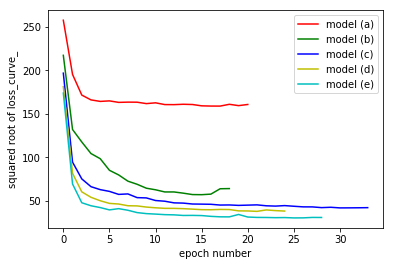

In [287]:
scaler = StandardScaler()
scaler0 = scaler.fit(X_train)
X_train_0 = scaler0.transform(X_train)
    
kf = KFold(n_splits=5)

layer_setting = [(2,), (10,), (20,), (30,), (40,)]
label = ['model (a)', 'model (b)', 'model (c)', 'model (d)', 'model (e)']
color = ['r', 'g', 'b', 'y', 'c']
plot_record = []

for i in range(5):
    MLP1 = MLPRegressor(activation='tanh', hidden_layer_sizes=layer_setting[i], solver = 'sgd', learning_rate='constant', random_state=42, learning_rate_init = 0.005, batch_size=5000)
    MLP1.fit(X_train_0, y_train) 
    loss_plot, = plt.plot(np.sqrt(MLP1.loss_curve_), color[i], label=label[i])
    plot_record.append(loss_plot)

plt.legend(handles=plot_record)
plt.xlabel('epoch number')
plt.ylabel('squared root of loss_curve_')
plt.show()

### 4)

In [288]:
kf = KFold(n_splits=5)

activation_layer = ['tanh', 'relu']

for i in range(2):
    MLP1 = MLPRegressor(activation=activation_layer[i], hidden_layer_sizes=(2,), solver = 'sgd', random_state=42, batch_size=5000)
    MSE = 0
    for train_index, test_index in kf.split(X_train, y_train):

        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train_0 = X_train.iloc[train_index]
        X_test_0 = X_train.iloc[test_index]
        y_train_0 = y_train[train_index]
        y_test_0 = y_train[test_index]

        scaler = StandardScaler()
        scaler.fit(X_train_0)
        X_train_0 = scaler.transform(X_train_0)
        X_test_0 = scaler.transform(X_test_0)

        meanval = np.mean([item for item in y_train_0 if not np.isnan(item)])
        index = np.isnan(y_train_0)
        y_train_0[index] = meanval

        MLP1.fit(X_train_0, y_train_0)
        y_predict = MLP1.predict(X_test_0)

        meanval = np.mean([item for item in y_test_0 if not np.isnan(item)])
        index = np.isnan(y_test_0)
        y_test_0[index] = meanval
        
        MSE = MSE + np.sqrt(np.mean((y_test_0 - y_predict) ** 2))
    print("Average RMSE with activation layer " + activation_layer[i] + " is: ", MSE / 5)

Average RMSE with activation layer tanh is:  231.992292187
Average RMSE with activation layer relu is:  110.82441999


### 5)

In [289]:
import sys
kf = KFold(n_splits=5)

solver = ['sgd', 'adam']
learning_rate = [1, 0.1, 0.01, 0.001]

for i in range(2):
    index1 = 0
    min_mse = sys.maxsize
    for j in range(4):
        MLP1 = MLPRegressor(learning_rate_init=learning_rate[j], activation='tanh', hidden_layer_sizes=(2,), solver=solver[i], random_state=42, batch_size=5000, momentum=0)
        MSE = 0
        for train_index, test_index in kf.split(X_train, y_train):

            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train_0 = X_train.iloc[train_index]
            X_test_0 = X_train.iloc[test_index]
            y_train_0 = y_train[train_index]
            y_test_0 = y_train[test_index]

            scaler = StandardScaler()
            scaler.fit(X_train_0)
            X_train_0 = scaler.transform(X_train_0)
            X_test_0 = scaler.transform(X_test_0)

            meanval = np.mean([item for item in y_train_0 if not np.isnan(item)])
            index = np.isnan(y_train_0)
            y_train_0[index] = meanval

            MLP1.fit(X_train_0, y_train_0)
            y_predict = MLP1.predict(X_test_0)

            meanval = np.mean([item for item in y_test_0 if not np.isnan(item)])
            index = np.isnan(y_test_0)
            y_test_0[index] = meanval

            MSE = MSE + np.sqrt(np.mean((y_test_0 - y_predict) ** 2))
            
        if(min_mse > MSE / 5):
            index1 = j
            min_mse = MSE / 5
            
    print("Average RMSE with " + solver[i] + " solver is: " + str(min_mse) + ", with the best learning rate as " + str(learning_rate[index1]))

Average RMSE with sgd solver is: 224.090636297, with the best learning rate as 0.1


/Users/cmk/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Average RMSE with adam solver is: 244.056511732, with the best learning rate as 0.1


# Question 4: Multi-level Model in Python (20 points)
In this problem, you will explore multi-level model using a python package [PyMC3](https://pymc-devs.github.io/pymc3/index.html#). The dataset "brew_by_year.csv" will be used in this question.  This dataset contains fields:

- `state`
- `state_id`
- `brew`
- `year`

Where 'brew' is the number of breweries in the state that year, and `state_id` is a unique ID for that state.

(a)  (2 pts) Plot the relationship between number of breweries and year, and draw a linearly regressed line ignoring the ID variable.

(b)  (2 pts) Plot the relationship between number of breweries and year, but this time, fit a different linear regression for each state.

(c)  (2 + 4 + 6 pts) Divide the dataset into training and test sets.  The training set contains the first 6 years of the measurements, and the test set contains the rest of the measurements. 
Build three different linear models:
- Global model:  a linear model using `brew` as the dependent variable and `year` as the independent variable. Pool all data and estimate one common regression model to assess the influence of the passage of time across the total number of breweries.
- Local model:  a different linear model for each state i.e., 51 different linear regressions. We are interested in whether different states actually follow separate regression models.
- Multilevel model:  Use the [PyMC3](http://pymc-devs.github.io/pymc3/notebooks/GLM-hierarchical.html#Partial-pooling:-Hierarchical-Regression-aka,-the-best-of-both-worlds) package to fit a multilevel model specified as follows:

\begin{align*}
\text{brew}_{it} &= \beta_{0i} + \beta_{1i} \text{year}_{it} + \epsilon_{it}\\
\beta_{0i} &= \beta_{00}  + \eta_{0i} \\
\beta_{1i} &= \beta_{10} + \eta_{1i} \\
\end{align*}

Predict the number of breweries for the next 2 years, and calculate the mean squared errors from the three models.

(d)  (2 pts) Briefly state what do $\beta_{00}$ and $\beta_{10}$ mean in this multilevel model.

(e) (2 pt) Visually assess from the trace plot whether the MLM specified in the problem is a reasonable choice.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np

data = pd.read_csv('brew_by_year.csv', index_col=0)
data['brew'] = (data['brew'] - np.mean(data['brew'])) / np.std(data['brew'])

# Specify the hyper-parameter of Multilevel model:
beta_00 = pm.Normal('mu_beta0', mu=0., sd=10)
eta_0i = pm.HalfCauchy('eta_0', 5)
beta_10 = pm.Normal('mu_beta1', mu=0., sd=10)
eta_1i = pm.HalfCauchy('eta1', 5)
    
# Intercept and Slope
beta_0i = pm.Normal('beta0', mu=beta_00, sd=eta_0i, shape=len(train_data.state_id.unique()))
beta_1i = pm.Normal('beta1', mu=beta_10, sd=eta_1i, shape=len(train_data.state_id.unique()))    
# Model error
eps = pm.HalfCauchy('eps', 5)

## Answer

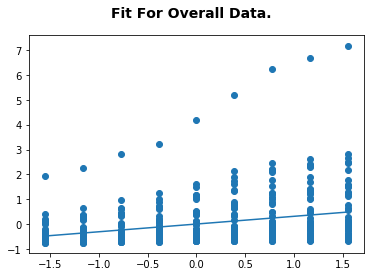

In [291]:
#4 - (a)
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
%matplotlib inline

data = pd.read_csv('brew_by_year.csv', index_col=0)
data['brew'] = (data['brew'] - np.mean(data['brew'])) / np.std(data['brew'])
data['year'] = (data['year'] - np.mean(data['year'])) / np.std(data['year'])
brew = np.matrix(data['brew'].values).T
year = np.matrix(data['year'].values).T
plt.scatter(data['year'],data['brew'])
plt.suptitle('Fit For Overall Data.', fontsize=14, fontweight='bold')
reg = linear_model.LinearRegression()
reg.fit(year,brew)
predicted_brew = reg.predict(year)
plt.plot(year, predicted_brew)
plt.show()

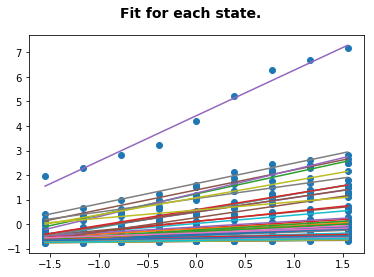

In [292]:
# 4 - (b), fit a different linear regression for each state. 
plt.scatter(data['year'],data['brew'])
plt.suptitle('Fit for each state.', fontsize=14, fontweight='bold')

states = data.state.unique()
for s in states:
    data_filter = data.loc[data['state'] == s]
    state_filter = np.matrix(data_filter['brew'].values).T
    year_filter = np.matrix(data_filter['year'].values).T
    reg.fit(year_filter, state_filter)
    predicted_brew = reg.predict(year_filter)
    plt.plot(year_filter, predicted_brew)
    
plt.show()

In [293]:
# 4 - (c)
# (c) (2 + 4 + 6 pts) Divide the dataset into training and test sets. 
#  The training set contains the first 6 years of the measurements, 
# and the test set contains the rest of the measurements. Build three different linear models:

# 4 - (c) - a
# Build a global model similar to (a)
# extract > 6 yrs --> starting from 0 - 5
data = pd.read_csv('brew_by_year.csv', index_col=0)
data['brew'] = (data['brew'] - np.mean(data['brew'])) / np.std(data['brew'])
training_set = data.loc[data['year'] <= 5]
testing_set = data.loc[data['year'] > 5]
# extract training/testing
brew_training = np.matrix(training_set['brew'].values).T
year_training = np.matrix(training_set['year'].values).T
brew_test = np.matrix(testing_set['brew'].values).T
year_test = np.matrix(testing_set['year'].values).T
# fit linear regression model
reg = linear_model.LinearRegression()
reg.fit(year_training, brew_training)
predicted_brew = reg.predict(year_test)
# calculate MSE
MSE = np.square(np.subtract(predicted_brew, brew_test)).mean()
print("Global Model MSE: ", MSE)

Global Model MSE:  1.6792813652


In [294]:
# 4 - (c) - b
# Local model: a different linear model for each state i.e., 51 different linear regressions. 
# We are interested in whether different states actually follow separate regression models. 
# Use LinearRegression from sklearn. This is similar to part b).

# extract the unique id for the states
states = data.state.unique()
mse_list = []
for state in states:
    training_set_local = training_set[data['state'] == state]
    brew_training, year_training = np.matrix(training_set_local['brew'].values).T, np.matrix(training_set_local['year'].values).T
    
    test_set_local = testing_set[data['state'] == state]
    brew_test, year_test = np.matrix(test_set_local['brew'].values).T, np.matrix(test_set_local['year'].values).T 
    
    reg = linear_model.LinearRegression()
    reg.fit(year_training, brew_training)
    predicted_brew = reg.predict(year_test)

    MSE_per_state = np.square(np.subtract(predicted_brew, brew_test)).mean()
    mse_list.append(MSE_per_state)
    print("MSE of Local Model:" + state, MSE_per_state)
    
print("MSE Average:", sum(mse_list) / len(mse_list))

MSE of Local Model:AK 0.000146435695879
MSE of Local Model:AL 0.000248324661173
MSE of Local Model:AR 0.000271978855042
MSE of Local Model:AZ 0.00630769802304
MSE of Local Model:CA 0.311957366174
MSE of Local Model:CO 0.0615128225158
MSE of Local Model:CT 0.0064611814262
MSE of Local Model:DC 0.00124899468563
MSE of Local Model:DE 0.00209231811923
MSE of Local Model:FL 0.100116988963
MSE of Local Model:GA 0.0121737397227
MSE of Local Model:HI 0.00136674360259
MSE of Local Model:IA 0.0073344080208
MSE of Local Model:ID 0.000881762151198
MSE of Local Model:IL 0.0098045981022
MSE of Local Model:IN 0.00781278550943
MSE of Local Model:KS 0.00438883181096
MSE of Local Model:KY 0.00284255961138
MSE of Local Model:LA 0.00676409188545
MSE of Local Model:MA 0.010381664375
MSE of Local Model:MD 0.00488523576868
MSE of Local Model:ME 0.0125413846785
MSE of Local Model:MI 0.0430265140213
MSE of Local Model:MN 0.00948948727856
MSE of Local Model:MO 0.0482447513491
MSE of Local Model:MS 0.00023148847

/Users/cmk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/Users/cmk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps_log__, beta1, beta0, eta1_log__, mu_beta1, eta_0_log__, mu_beta0]
100%|██████████| 2500/2500 [00:14<00:00, 170.08it/s]


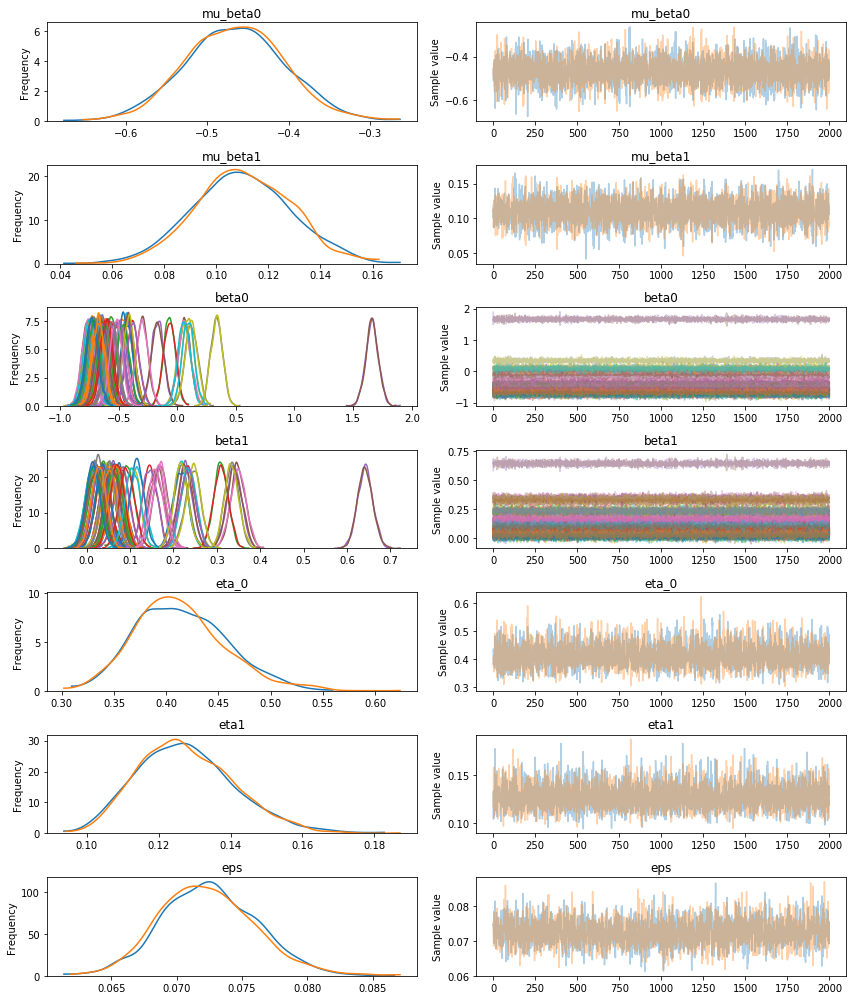

MSE of MultiLevel Model: 0.0264228917349


/Users/cmk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [295]:
# 4 - (c) - c.
# Multilevel model: Use the PyMC3 package to fit a multilevel model specified as follows:
# Note the usage of pm.sample which generates samples from the posterior and pm.traceplot 
# which provides a nice set of plots showing the estimated posterior distribution.
import pandas as pd
data = pd.read_csv('brew_by_year.csv', index_col=0)
# need to do the scaling
data['brew'] = (data['brew'] - np.mean(data['brew'])) / np.std(data['brew'])
training_set, testing_set = data.loc[data['year'] <= 5], data.loc[data['year'] > 5]

id_training, year_training, brew_training, id_testing = training_set['state_id'].values, training_set['year'].values, training_set['brew'].values, testing_set['state_id'].values 

with pm.Model() as model:
    # Specify the hyper-parameter of Multilevel model:
    
    # Regression coefficients, same paramter as the reference
    beta_00 = pm.Normal('mu_beta0', mu=0., sd=10)
    eta_0i = pm.HalfCauchy('eta_0', 5)
    beta_10 = pm.Normal('mu_beta1', mu=0., sd=10)
    eta_1i = pm.HalfCauchy('eta1', 5)

    # Intercept and Slope
    beta_0i = pm.Normal('beta0', mu=beta_00, sd=eta_0i, shape=len(training_set.state_id.unique()))
    beta_1i = pm.Normal('beta1', mu=beta_10, sd=eta_1i, shape=len(training_set.state_id.unique())) 

    # Model error
    eps = pm.HalfCauchy('eps', 5)  
    
    # Expected value
    brew_hat = beta_0i[id_training] + beta_1i[id_training] * year_training
    
    # Observations with normal-distributed error
    y = pm.Normal('y', mu=brew_hat, sd=eps, observed=brew_training)


with model:
    # param = 2000     
    trace = pm.sample(draws=2000,n_init=1000)

pm.traceplot(trace);
plt.show()

mse_multi = []
states = data.state_id.unique()
for state in states:
    mytesting_set = testing_set[data['state_id'] == state]
    mybrew_testing = mytesting_set['brew'].values
    myyear_testing = mytesting_set['year'].values

    beta_0i = np.mean(trace['beta0'][:,state])
    beta_1i = np.mean(trace['beta1'][:,state])
    mybrew_predict = beta_0i + beta_1i * myyear_testing

    mse_multi.append(np.square(np.subtract(mybrew_predict, mybrew_testing)).mean())
    
print('MSE of MultiLevel Model:', sum(mse_multi) / len(mse_multi))


(d) (2 pts) Briefly state what do β00β00 and β10β10 mean in this multilevel model.

$\beta_{00}$ is the intercept.  $\beta_{10}$ is the regression coefficient bewteen the brew and year.

(e) (1 pt) Visually assess from the trace plot whether the MLM specified in the problem is a reasonable choice. It's a good approach since we can tell the difference from the plot.

# Question 5: Decision Tree using Python (5 pts)
In this problem, you will model the data using decision trees to perform a classification task on the energy dataset provided. The dataset has been preprocessed. Using the class tree.DecisionTreeClassifier (http://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree), build two different trees with a maximum depth of two using the split criteria (i) Gini and (ii) Entropy. Use entire data to build trees. Plot the two trees. If your classifier object is called clf, use the following commands to save the generated tree as a '.dot' file that can be used to visualize the tree using Webgraphviz: http://www.webgraphviz.com/

Hint: see  http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html

Copy paste the contents of your '.dot' file into the text window on the website to visualize the trees. At which node(s) do they differ?

In [296]:

import pandas as pd
import numpy as np

data = pd.read_csv('energydata_complete.csv') 

y = data['Appliances']
X = data.drop(['date','Appliances', 'rv1', 'rv2'], axis = 1)


from dateutil import parser
timeData = np.array(data['date'])

days = []
hours = []
for line in range(len(timeData)):
    day = parser.parse(timeData[line]).weekday()
    hour = parser.parse(timeData[line]).hour
    days.append(day)
    hours.append(hour)
    
X = pd.concat([X, pd.get_dummies(days), pd.get_dummies(hours)], axis = 1)

In [297]:
# 5 - (i) use 'Gini' as the entropy split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO

clf_gini = DecisionTreeClassifier(criterion = "gini", max_depth=2)
clf_gini.fit(X,y)

with open("decision_tree_gini.dot", 'w') as f:
    f = tree.export_graphviz(clf_gini, out_file=f)
    
clf_entropy = DecisionTreeClassifier(criterion = "entropy", max_depth = 2)
clf_entropy.fit(X,y)

with open("decision_tree_entropy.dot", 'w') as f:
    f = tree.export_graphviz(clf_entropy, out_file=f)

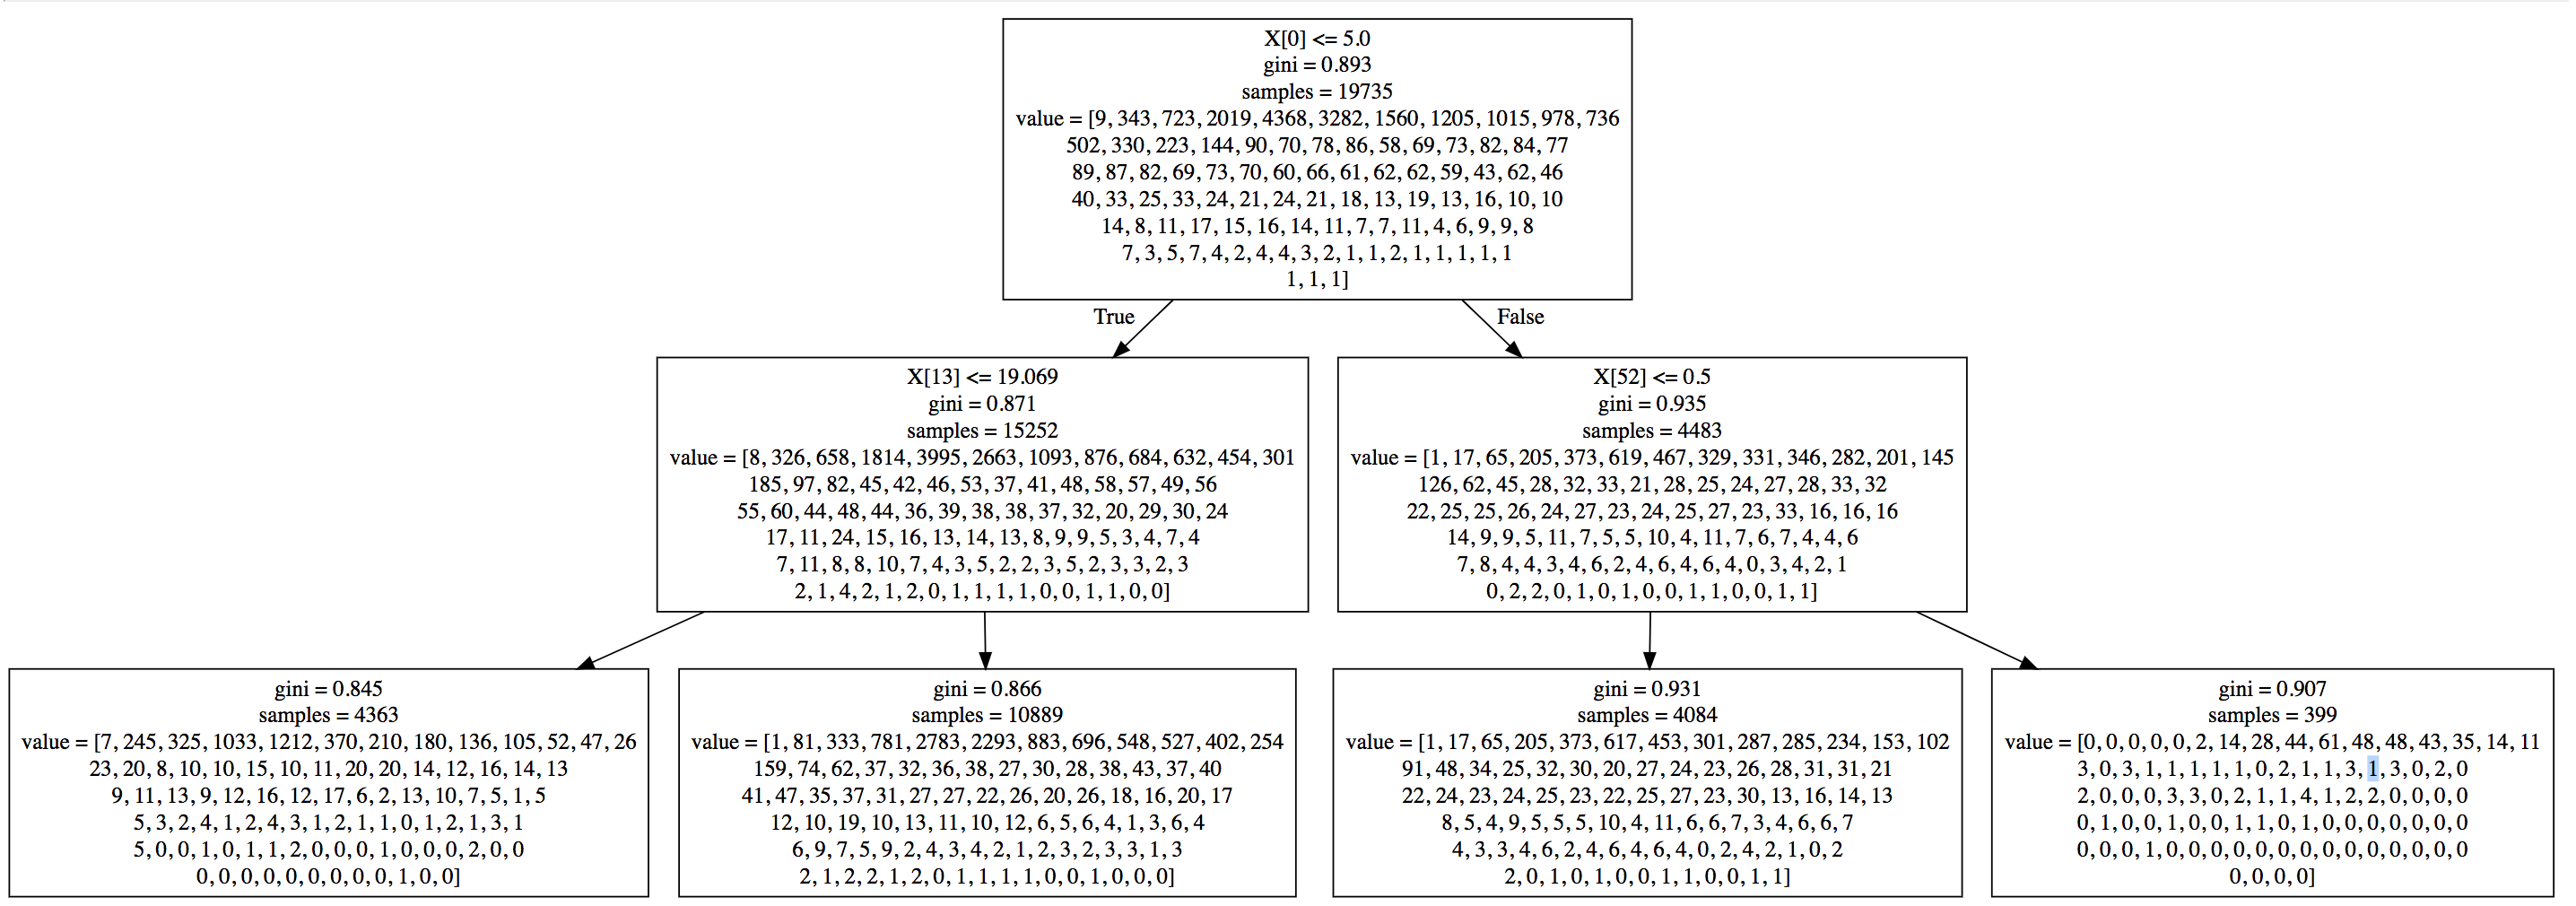

In [298]:
from IPython.display import Image
Image("tree_gini.png", width=1000, height=2000)

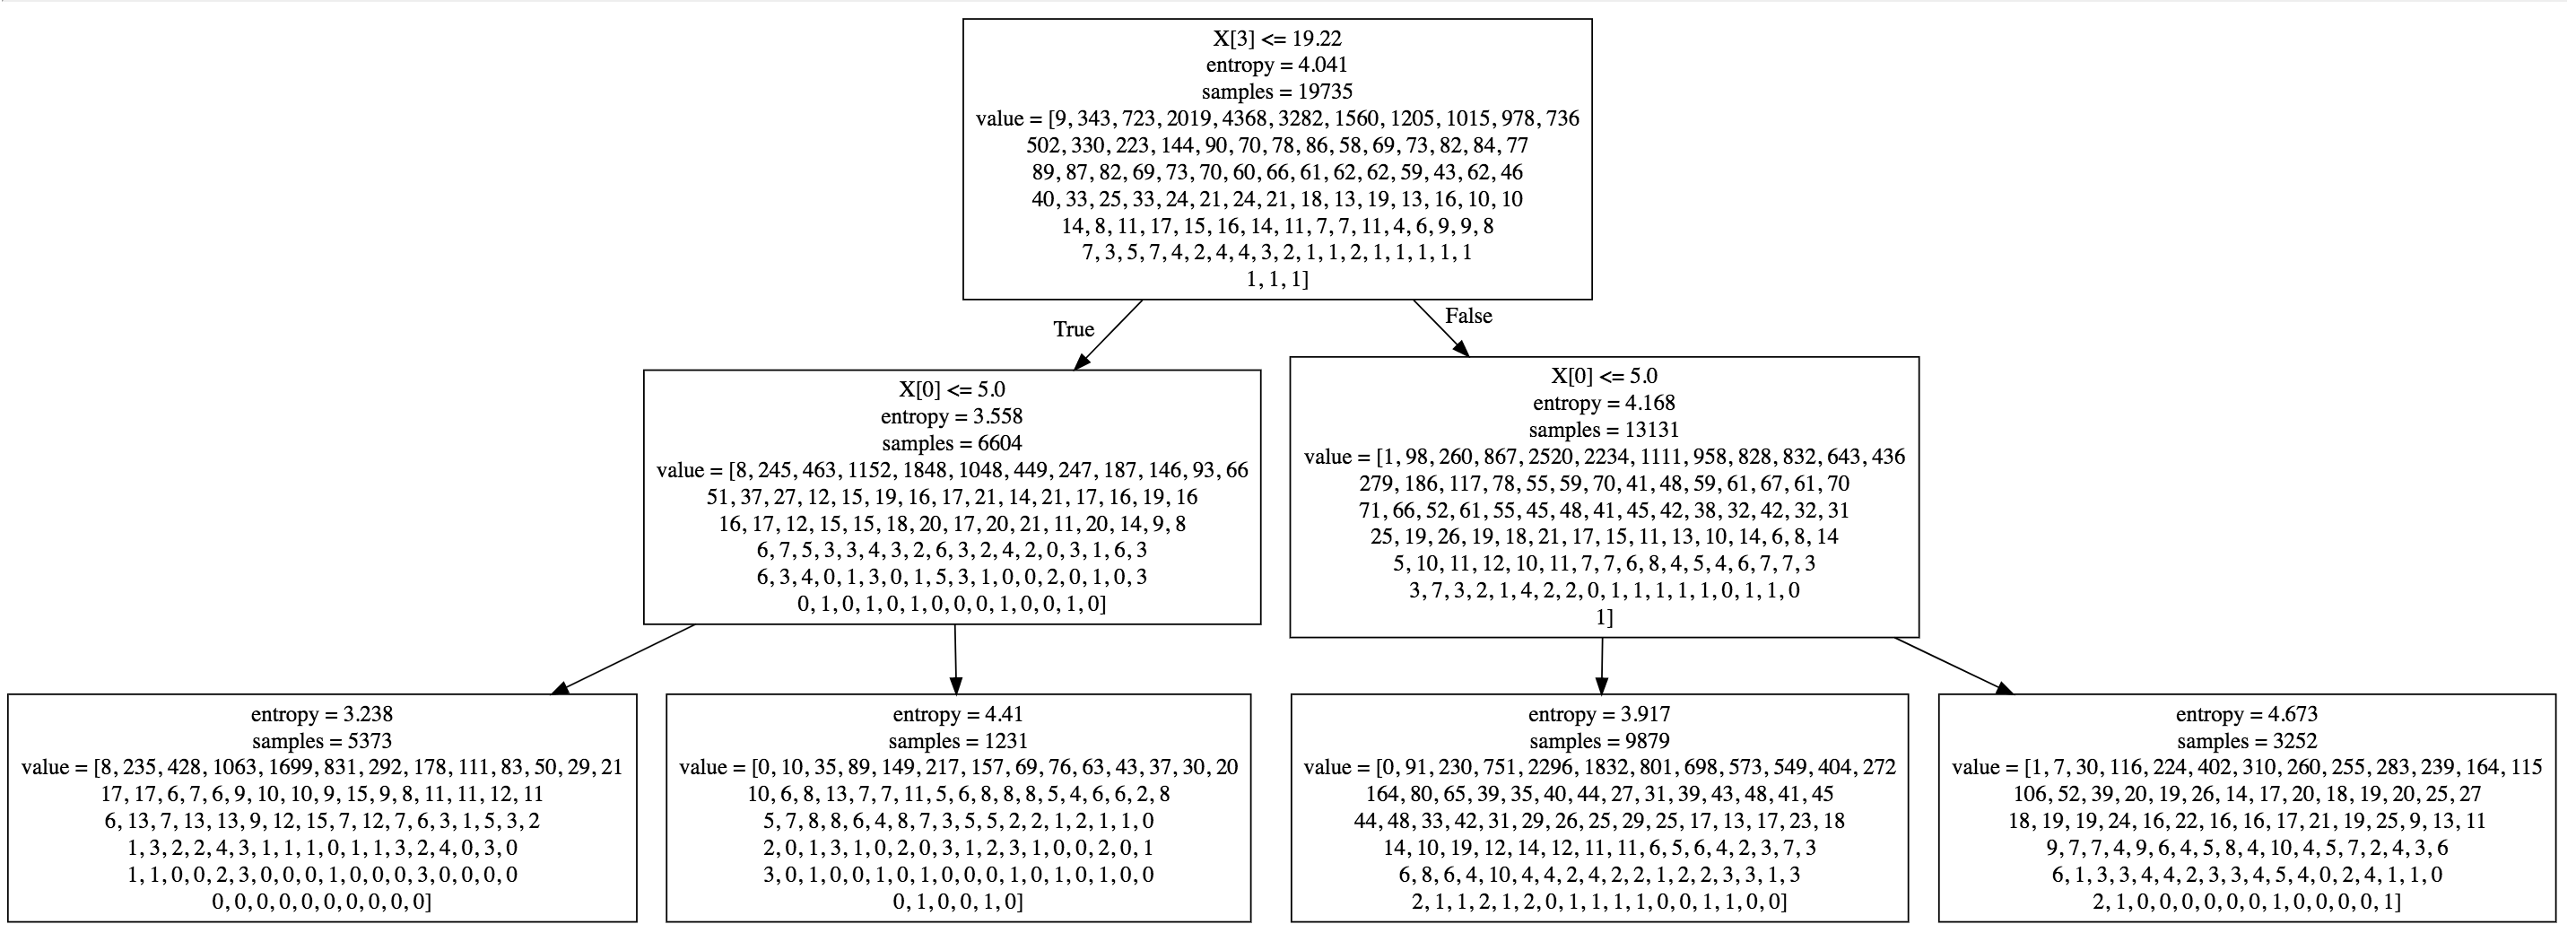

In [299]:
from IPython.display import Image
Image("tree_entropy.png", width=1000, height=2000)

At which node(s) do they differ? Starting from the very top of the spliting.

# Question 6. (2+5+3=10 pts) Bayes Decision Theory
a. Explain what you understand by class-conditional likelihood, class priors, and posterior probability of a class given an input, and the relationship between them. Please define all symbols and equations used explicitly.
( 2 points )

b. Suppose you want to learn a binary classifier to predict whether or not a customer will buy a TV. The class label is 0 if the customer does not buy a TV and 1 if they do. For each customer, you are given two features, $x_1$ is the per hour salary and $x_2$ is the age. Assume that the class conditional distribution $p([x_1 , x_2]|C)$ is Gaussian. The mean salary and age of the people who do buy a TV is 15 and 40 respectively and that of those who don’t is 8.5 and 25. The first class of customers, $\sigma_1$ = 1, $\sigma_2 = 2$ and $\rho = 0$. For the second class of customers, $\sigma_1$ = 3, $\sigma_2 = 2$ and $\rho = 0$.(Refer HW1 on how to construct a covariance matrix with this information). Further, your sales data suggests that only 1 in 3 people actually bought a TV in the last few years. Mathematically derive the (optimal) Bayes decision boundary for this problem. (5 points)

c. Now sample 1000 customers from each class (C = 0, 1) under the assumed distribution and the estimated parameters and plot their features. Additionally, plot the decision boundary you obtained in the part (b) on the same plot. (3 points)

## ANSWER

(a)
class-conditional likelihood is the probability density function for x given ω, which means: p(x|ω)

On the other hand, class priors probaility is p(ω).

Posterior probability is the probability of a certain state of nature given our observables: P(ω|x).

The relationship between them is: (Bayes Inference)

$$P(ω|x) = \frac{P(x|ω)P(ω)}{P(x)}$$

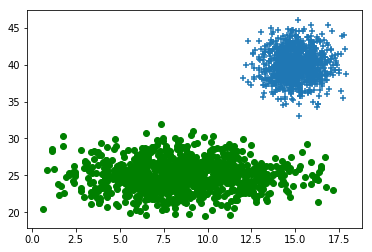

In [301]:
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import scipy
from sklearn import svm

sample_amount = 1000
mu_vec1 = np.array([15,40])
cov_mat1 = np.array([[1,0],[0,4]])
x1_samples = np.random.multivariate_normal(mu_vec1, cov_mat1, sample_amount)
mu_vec1 = mu_vec1.reshape(1,2).T # to 1-col vector

mu_vec2 = np.array([8.5,25])
cov_mat2 = np.array([[9,0],[0,4]])
x2_samples = np.random.multivariate_normal(mu_vec2, cov_mat2, sample_amount)
mu_vec2 = mu_vec2.reshape(1,2).T


fig = plt.figure()


plt.scatter(x1_samples[:,0],x1_samples[:,1], marker='+')
plt.scatter(x2_samples[:,0],x2_samples[:,1], c= 'green', marker='o')          
#           
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# x = np.arange(-5, 5, 0.25)
# y = np.arange(-5, 5, 0.25)
# X, Y = np.meshgrid(x, y)
# F = -229.95 + 3.75 * Y + 14.06 * X - 0.44 * X*X

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X, Y, F)
# plt.show()

(1000,) (1000,)
(1000,) (1000,)


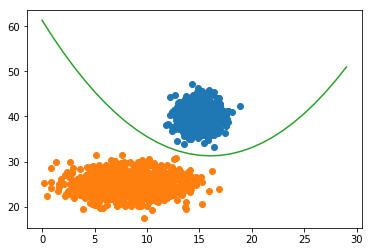

In [302]:
import matplotlib.pyplot as plt
import numpy as np

[X1,X2] = np.random.multivariate_normal(mean=[15,40],cov=[[1,0],[0,4]],size = 1000).T
print(X1.shape, X2.shape)
plt.plot(X1,X2,'o')
[X1,X2]=np.random.multivariate_normal(mean=[8.5,25],cov=[[9,0],[0,4]],size = 1000).T
print(X2.shape, X2.shape)
plt.plot(X1,X2,'o')

X1 = np.array(range(0,30))
X2 = 0.117 * X1**2 - 3.75 * X1 + 61.32
plt.plot(X1,X2)